In [1]:
import random as rand
import numpy as np
from functions import *

In [2]:
def dyn_vax(beta,gamma,omega,graph,radius,tmax,block = True):
    #Note that with omega = 0, the model is the SIR model
    S = []
    I = []
    R = []
    V = []
    
    S.append(len(graph.nodes)-1)
    I.append(1)
    R.append(0)
    V.append(0)

    list_nodes = list(graph.nodes)
    if len(list_nodes) == 0:
        return S,I,R,V
    
    #choose a random node to be infected
    patient0 = rand.choice(list_nodes)
    infected = [patient0]
    recovered = []
    vaccinated = []
    susceptible = [i for i in list_nodes if i not in infected]

    t=0
    while t < tmax:
        inf1 = infected.copy() #to avoid changing the list while iterating
        rand.shuffle(inf1) #shuffle the list of infected nodes to avoid bias
        newly_infected = []
        for node in inf1:
            tot_neigh = nx.single_source_shortest_path_length(graph,node,radius)
            neigh = set(key for key, value in tot_neigh.items() if value <= radius) if block else set(key for key, value in tot_neigh.items() if value == radius)

            #intersection between neigh and susceptible
            for neighbor in neigh.intersection(susceptible):
                k_vax = rand.random()
                k_inf = rand.random()
                if k_vax < omega:
                    #print("k: "+str(k)+": new vaccinated node: "+str(neighbor))
                    vaccinated.append(neighbor)
                    susceptible.remove(neighbor)
                elif k_inf < beta:
                    #print("k: "+str(k)+": new infected node: "+str(neighbor))
                    infected.append(neighbor)
                    newly_infected.append(neighbor)
                    susceptible.remove(neighbor)

        for node in infected:
            if node not in newly_infected:
                if rand.random() < gamma:
                    #print("node: "+str(node)+" is recovered")
                    recovered.append(node)
                    infected.remove(node)
        t += 1
        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        V.append(len(vaccinated))
    return S,I,R,V

In [9]:
omega = 0.6 #vaccination probability
beta = 1 #infection probability
gamma = 1 #recover probability
t_max = 50 #number of steps of the process
n_nodes = 10000 #number of nodes in the network
niter = 500 #number of iterations
radius = 2 #radius of the vaccination
Block = True #block or ring
prob_vec = prob_list_powerlaw(2.5,3,400) #definition of the probability distribution of the network
degree_vec_in = discrete_samples(prob_vec,n_nodes)
G = config_model(degree_vec_in)



In [10]:
iterat = 0
S = [0]*t_max
I = [0]*t_max
R = [0]*t_max
V = [0]*t_max
while iterat < niter:
    printProgressBar(iterat,niter,prefix = "Progress",suffix = "Complete",length = 50)
    degree_vec_in = discrete_samples(prob_vec,n_nodes)
    G = config_model(degree_vec_in)
    sir = dyn_vax(beta,gamma,omega,G,radius,t_max,block = Block) #block = True for block vaccination
    S = [S[i]+sir[0][i] for i in range(0,len(S))]
    I = [I[i]+sir[1][i] for i in range(0,len(I))]
    R = [R[i]+sir[2][i] for i in range(0,len(R))]
    V = [V[i]+sir[3][i] for i in range(0,len(V))]
    iterat += 1

#average
S = [i/(niter*n_nodes) for i in S]
I = [i/(niter*n_nodes) for i in I]
R = [i/(niter*n_nodes) for i in R]
V = [i/(niter*n_nodes) for i in V]
print("Results for omega :"+str(omega)+", beta: "+str(beta)+ "::: +\n"+ "Recovered: "+str(R[-1])+"\n"+"Infected: "+str(I[-1])+"\n"+"Susceptible: "+str(S[-1])+"\n"+"Vaccinated: "+str(V[-1]))

Results for omega :0.6, beta: 1::: +███████████████████████-| 99.80% Complete
Recovered: 0.3993736
Infected: 0.0
Susceptible: 0.0003106
Vaccinated: 0.6003158


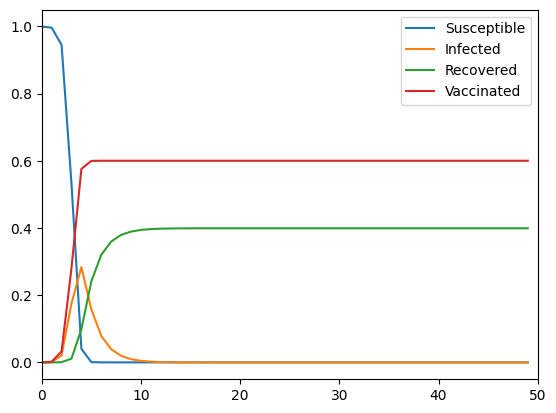

In [11]:
#plot
import matplotlib.pyplot as plt
plt.plot(S,label = "Susceptible")
plt.plot(I,label = "Infected")
plt.plot(R,label = "Recovered")
plt.plot(V,label = "Vaccinated")
plt.legend()
#change xlim    
plt.xlim(0,50)
plt.show()


In [ ]:
path = ""
Omega = np.linspace(0,0.4,100)
Beta = np.linspace(0,1,100)
niter = 1000
import pandas as pd
df = pd.DataFrame(columns = ["Omega", "Beta", "t", "Recovered", "Infected", "Susceptible", "Vaccinated"])
#save the results in a dataframe
df.to_csv(path+"results.csv",index = False)
for omega in Omega:
    for beta in Beta:
        iterat = 0
        S = [0]*t_max
        I = [0]*t_max
        R = [0]*t_max
        V = [0]*t_max
        while iterat < niter:
            printProgressBar(iterat,niter,prefix = "Progress",suffix = "Complete",length = 50)
            degree_vec_in = discrete_samples(prob_vec,n_nodes)
            G = config_model(degree_vec_in)
            sir = dyn_vax(beta,gamma,omega,G,radius,t_max,block = Block) #block = True for block vaccination
            S = [S[i]+sir[0][i] for i in range(0,len(S))]
            I = [I[i]+sir[1][i] for i in range(0,len(I))]
            R = [R[i]+sir[2][i] for i in range(0,len(R))]
            V = [V[i]+sir[3][i] for i in range(0,len(V))]
            iterat += 1
        
        #average
        S = [i/(niter*n_nodes) for i in S]
        I = [i/(niter*n_nodes) for i in I]
        R = [i/(niter*n_nodes) for i in R]
        V = [i/(niter*n_nodes) for i in V]
        print("Results for omega :"+str(omega)+", beta: "+str(beta)+ "::: +\n"+ "Recovered: "+str(R[-1])+"\n"+"Infected: "+str(I[-1])+"\n"+"Susceptible: "+str(S[-1])+"\n"+"Vaccinated: "+str(V[-1]))
        #load df
        df = pd.read_csv(path+"results.csv")
        for t in range(0,t_max):
            df = df._append({"Omega": omega, "Beta": beta, "t": t, "Recovered": R[t], "Infected": I[t], "Susceptible": S[t], "Vaccinated": V[t]}, ignore_index = True)

        df.to_csv(path+"results.csv",index = False)
